In [2]:
import numpy as np
import json
import math
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
import re
import matplotlib.pyplot as plt

# Initial Data Processing of Text in News Articles
In this notebook, I explore the news articles we scraped from the guardian. I have written functions that have the following functionalities:
    - tokenize a string
    - tokenize an article and remove stopwords
    - create doc term matrix
    - create inverted index
    - computes inverse document frequencies (idf values)
    - removes words that do not appear in many documents
    - creates tfidf matrix
    - selects words in a document with the k highest tfidf scores

## Helper Functions

In [13]:
def tokenize(text):
    """Returns a list of words that make up the text.
    
    Note: for simplicity, lowercase everything.
    Requirement: Use Regex to satisfy this function
    
    Params: {text: String}
    Returns: List
    """
    stop_words = stopwords.words('english')
    regex = r"([a-zA-Z]+)"
    tokens = re.findall(regex, text.lower())
    return [t for t in tokens if not t in stop_words]

In [14]:
def tokenize_articles(input_data, feature_name, tokenize_method):
    """ adds tokenized transcript (or title) as a feature of each document in dataset
    
    Arguments
    =========
    news_data: list of dictionaries
    
    feature_name: String
    
    tokenize_method: function
    
    Returns 
    =======
    data set with tokenized text for specified feature
    
    """
    for article in input_data:
        new_feature_name = feature_name + '_toks'
        article[new_feature_name] = tokenize_method(article[feature_name])
    return input_data

In [5]:
def create_doc_term_matrix(input_data, feature_name):
    """creates the doc_term matrix
    
    Arguments
    =========
    news_data: list of dictionaries
    
    feature_name: String
    
    Returns
    =======
    list of dictionaries where keys are the types in a document
    corresponding to the index of the list
    
    """
    matrix = []
    for article in input_data:
        tokens = article[feature_name]
        info = {}
        for t in set(tokens):
            info[t] = tokens.count(t)
        info = {k: v for k, v in sorted(info.items(), key=lambda item: item[1], reverse = True)}
        matrix.append(info)
    return matrix

In [6]:
def create_inverted_index(input_doc_term_matrix):
    """creates the inverted index
    
    Arguments
    =========
    input_doc_term_matrix: list of dictionaries
    
    Returns
    =======
    {String : list of tuples}
    
    """
    idx = {}
    doc_id = 0
    for doc in input_doc_term_matrix:
        for key, val in doc.items():
            if idx.get(key) is None:
                idx[key] = []
            idx.get(key).append((doc_id, val))
        doc_id+=1
    return idx

$$idf(i) = \frac{1}{1 + log(df(i))}$$

In [7]:
def create_idf(input_inverted_index):
    """computes the inverse document frequency of each type in dataset
    
    Arguments
    =========
    input_inverted_index: {String : list of tuples}
    
    Returns
    =======
    Dictionary {String : Float}
    
    """
    idf = {}
    for key,val in input_inverted_index.items():
        idf[key] = 1/math.log(1+len(val))
        #idf[key] = 1/(1+len(val))
    return idf

In [8]:
def create_tfidf_matrix(input_doc_term_matrix, input_idf):
    """creates tf-idf matrix
    
    Arguments
    =========
    input_doc_term_matrix: list of dictionaries
    
    input_idf: {String: Float}
    
    Returns
    =======
    list of dictionaries
    
    """
    matrix = []
    for doc in input_doc_term_matrix:
        info = {}
        for key,tf in doc.items():
            idf = 0
            if (input_idf.get(key) is not None):
                idf = input_idf.get(key)
            info[key] = tf*idf
        info = {k: v for k, v in sorted(info.items(), key=lambda item: item[1], reverse = True)}
        matrix.append(info)
    return matrix

In [9]:
def remove_non_frequent_types(input_inverted_index, min_df):
    """Removes terms from inverted index 
    that appear in less than min_df documents
    
    Arguments
    =========
    input_inverted_index: {String : list of tuples}
    
    min_df: Int
    
    Returns
    =======
    {String : List of Tuples}
    
    """
    total_types = len(input_inverted_index)
    idx_copy = input_inverted_index.copy()
    count = 0
    for key,val in idx_copy.items():
        if (len(val) < min_df):
            del input_inverted_index[key]
            count+=1
    print("Percent of Types Removed: ", count/(total_types*1.0))
    print("Number of Types Remaining: ", total_types - count)
    return input_inverted_index

## Main Method Begins in the Cell Below

In [10]:
with open('theguardian.json') as json_file:
    data = json.load(json_file)

In [11]:
num_articles = len(data)
print(str(num_articles) + ' articles loaded')
print('Each article has the following features:')
print(data[0].keys())

386 articles loaded
Each article has the following features:
dict_keys(['title', 'url', 'date', 'transcript', 'source'])


In [15]:
# IF GETTING AN ERROR, RUN THE CODE IN THE LINE BELOW
# nltk.download('stopwords')
data = tokenize_articles(data, 'transcript', tokenize)
data = tokenize_articles(data, 'title', tokenize)

In [16]:
doc_term_matrix = create_doc_term_matrix(data, 'transcript_toks')
inverted_index = create_inverted_index(doc_term_matrix)

In [17]:
inverted_index = remove_non_frequent_types(inverted_index, 2)
idf_values = create_idf(inverted_index)

Percent of Types Removed:  0.5082999666333
Number of Types Remaining:  11789


In [18]:
tfidf_matrix = create_tfidf_matrix(doc_term_matrix, idf_values)

## Analyzing TFIDF Results

In [19]:
def get_top_k_terms(doc_id, k, input_tfidf_matrix):
    """get the words in a document with the k highest tfidf scores
    
    Arguments
    =========
    doc_id: int
    
    k: int
    
    input_tfidf_matrix: List of Dictionaries
    
    
    Returns
    =======
    List of Tuples
    
    """
    doc = input_tfidf_matrix[doc_id]
    top_k = {}
    count = 0
    for key,val in doc.items():
        top_k[key] = val
        count+=1
        if (count==k):
            break
    return top_k

In [22]:
stemmer = PorterStemmer()
k = 10
for i in range(len(tfidf_matrix)):
    print('######### Top ' + str(k) + ' words')
    for w in get_top_k_terms(i, k, tfidf_matrix).keys():
        print(w + "   |   " + stemmer.stem(w))

######### Top 10 words
salmon   |   salmon
virus   |   viru
quarantine   |   quarantin
tested   |   test
veterinary   |   veterinari
fish   |   fish
archipelago   |   archipelago
laboratory   |   laboratori
test   |   test
said   |   said
######### Top 10 words
nhs   |   nh
choir   |   choir
singing   |   sing
hospital   |   hospit
virtual   |   virtual
staff   |   staff
sprayed   |   spray
coronavirus   |   coronaviru
pupils   |   pupil
said   |   said
######### Top 10 words
us   |   us
workers   |   worker
pandemic   |   pandem
catastrophe   |   catastroph
disasters   |   disast
conservatives   |   conserv
often   |   often
elites   |   elit
disaster   |   disast
new   |   new
######### Top 10 words
reef   |   reef
corals   |   coral
reefs   |   reef
bleaching   |   bleach
coral   |   coral
dive   |   dive
marine   |   marin
offspring   |   offspr
mass   |   mass
temperatures   |   temperatur
######### Top 10 words
covid   |   covid
lockdown   |   lockdown
read   |   read
minute   | 

service   |   servic
points   |   point
people   |   peopl
barber   |   barber
capital   |   capit
says   |   say
prescription   |   prescript
get   |   get
######### Top 10 words
syrian   |   syrian
roast   |   roast
eggs   |   egg
calais   |   calai
refugees   |   refuge
jungle   |   jungl
uk   |   uk
food   |   food
camp   |   camp
menu   |   menu
######### Top 10 words
namibia   |   namibia
veterinary   |   veterinari
pharmacists   |   pharmacist
vets   |   vet
pharmacy   |   pharmaci
meat   |   meat
antibiotics   |   antibiot
harper   |   harper
animals   |   anim
pharmacist   |   pharmacist
######### Top 10 words
device   |   devic
water   |   water
wang   |   wang
saline   |   salin
solar   |   solar
cell   |   cell
par   |   par
distillation   |   distil
warms   |   warm
tier   |   tier
######### Top 10 words
shoes   |   shoe
attendance   |   attend
flip   |   flip
slippers   |   slipper
indians   |   indian
old   |   old
barefoot   |   barefoot
converting   |   convert
pairs  

airbnb   |   airbnb
rentals   |   rental
homes   |   home
house   |   hous
rental   |   rental
nationals   |   nation
buy   |   buy
######### Top 10 words
democracy   |   democraci
health   |   health
cardiovascular   |   cardiovascular
countries   |   countri
democratic   |   democrat
democracies   |   democraci
metrics   |   metric
evaluation   |   evalu
government   |   govern
study   |   studi
######### Top 10 words
week   |   week
productivity   |   product
work   |   work
day   |   day
said   |   said
shorter   |   shorter
hours   |   hour
cooper   |   cooper
leisure   |   leisur
four   |   four
######### Top 10 words
week   |   week
time   |   time
said   |   said
lighting   |   light
productivity   |   product
day   |   day
staff   |   staff
four   |   four
shorter   |   shorter
switched   |   switch
######### Top 10 words
players   |   player
coaches   |   coach
rugby   |   rugbi
boys   |   boy
mentors   |   mentor
cricket   |   cricket
kumar   |   kumar
manish   |   manish
ma

says   |   say
corey   |   corey
kids   |   kid
fellowship   |   fellowship
guilt   |   guilt
crafts   |   craft
parent   |   parent
hall   |   hall
######### Top 10 words
hemp   |   hemp
cannabis   |   cannabi
wheat   |   wheat
cultivation   |   cultiv
italy   |   itali
land   |   land
agricultural   |   agricultur
jars   |   jar
pharmaceutical   |   pharmaceut
mafia   |   mafia
######### Top 10 words
iranian   |   iranian
cleric   |   cleric
iran   |   iran
books   |   book
villages   |   villag
intellectual   |   intellectu
fairytales   |   fairytal
bear   |   bear
said   |   said
children   |   children
######### Top 10 words
audio   |   audio
film   |   film
app   |   app
prasad   |   prasad
cinema   |   cinema
movie   |   movi
movies   |   movi
descriptions   |   descript
films   |   film
blind   |   blind
######### Top 10 words
swimming   |   swim
swim   |   swim
olympics   |   olymp
swimmer   |   swimmer
says   |   say
damascus   |   damascu
go   |   go
olympic   |   olymp
refu

hl   |   hl
r   |   r
e   |   e
public   |   public
town   |   town
privatisation   |   privatis
grid   |   grid
ownership   |   ownership
turbines   |   turbin
epic   |   epic
######### Top 10 words
solar   |   solar
pv   |   pv
silicon   |   silicon
panels   |   panel
efficiency   |   effici
cells   |   cell
cell   |   cell
based   |   base
technology   |   technolog
oxford   |   oxford
######### Top 10 words
bali   |   bali
rubbish   |   rubbish
beaches   |   beach
island   |   island
cleanup   |   cleanup
cleanups   |   cleanup
mounds   |   mound
bye   |   bye
waste   |   wast
one   |   one
######### Top 10 words
rough   |   rough
bite   |   bite
sleepers   |   sleeper
housing   |   hous
scottish   |   scottish
sleeping   |   sleep
support   |   support
associations   |   associ
edinburgh   |   edinburgh
homelessness   |   homeless
######### Top 10 words
ttir   |   ttir
iceland   |   iceland
gender   |   gender
says   |   say
pay   |   pay
equal   |   equal
icelandic   |   iceland


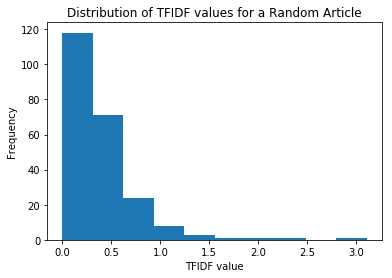

In [18]:
plt.hist(tfidf_matrix[0].values())
plt.title("Distribution of TFIDF values for a Random Article")
plt.xlabel("TFIDF value")
plt.ylabel("Frequency")
plt.show()

# Code below should fail to run but I might edit and use later 

In [ ]:
def num_types_trimmed(doc_freq, min_df = 0, max_df = 1.0, left = False, right = False):
    count = 0
    for key,val in doc_freq.items():
        if (left):
            if val <= min_df:
                count+=1
        if (right):
            #print(val/(1.0*num_articles))
            if val/(1.0*num_articles) >= max_df:
                print(key)
                count+=1
    return count/total_num_types

In [ ]:
print('Proportion of Types Removed: ', num_types_trimmed(doc_freq, min_df=1, max_df=.70, left=True, right=False))

In [ ]:
y = []
for i in range(1,21):
    y.append(num_types_trimmed(df, min_df=i, max_df=.70, left=True, right=False))
plt.bar(range(1,21), y)
plt.title('Proportion of words that appear in less than k documents')
plt.xticks(range(1,21,2))
plt.show()

In [ ]:
num_types_trimmed(df, min_df=1, max_df=.70, left=False, right=True)